In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

In [3]:
import copy
from scipy import stats
from sklearn.preprocessing import PowerTransformer

In [4]:
df = pd.read_csv("clean_data.csv", index_col=0)
df

,required_age,price,relase_year,Violent,Simulation,Free to Play,Early Access,Strategy,Gore,Sexual Content,...,Steam Cloud,VR Support,LAN Co-op,Multi-player,Additional High-Quality Audio,Remote Play on Tablet,windows,mac,linux,score
0,0,1379,2021,0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0.955032
1,0,399,2021,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0.733668
2,0,499,2021,0,1,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0.921053
3,0,5999,2022,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0.953191
4,0,799,2021,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.971429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,599,2017,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,1,1,0.921875
9996,0,1679,2020,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0.660407
9997,0,4999,2020,0,0,0,0,0,0,0,...,1,0,0,1,0,1,1,0,0,0.677665
9998,0,1999,2017,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,1,0,0.973799


# Fitting linear regression with all variables

# check IVs for correlation

In [7]:
corr = df.iloc[:,0:-1].corr()
#corr.style.background_gradient(cmap='coolwarm')

In [8]:
high_corr1, high_corr2 = np.where(np.abs(corr)>0.5)

In [9]:
#high_corr1, high_corr2

## see which IVs have correlation higher than 0.5

In [10]:
# get indicics of highly correlated features in feature matrix
A = []
for i in range(len(high_corr1)):
    if high_corr1[i]!=high_corr2[i]:
        A.append((high_corr1[i],high_corr2[i]))
    

In [11]:
#len(A)

In [12]:
# transform indices to names of columns, add to tuple together with correlation of the features
B = []
for i in range(len(A)):
    B.append((df.columns[A[i][0]],df.columns[A[i][1]], round(corr.iloc[A[i][0],A[i][1]],3)))
    

In [13]:
B

[('Violent', 'Gore', 0.689),
 ('Gore', 'Violent', 0.689),
 ('Sexual Content', 'Nudity', 0.572),
 ('Nudity', 'Sexual Content', 0.572),
 ('Massively Multiplayer', 'MMO', 0.671),
 ('Online Co-op', 'Co-op', 0.753),
 ('Online Co-op', 'Multi-player', 0.515),
 ('PvP', 'Online PvP', 0.896),
 ('PvP', 'Shared/Split Screen PvP', 0.57),
 ('PvP', 'Multi-player', 0.632),
 ('Co-op', 'Online Co-op', 0.753),
 ('Co-op', 'Multi-player', 0.654),
 ('Includes level editor', 'Steam Workshop', 0.507),
 ('Remote Play Together', 'Shared/Split Screen PvP', 0.641),
 ('Remote Play Together', 'Shared/Split Screen Co-op', 0.611),
 ('Remote Play Together', 'Shared/Split Screen', 0.809),
 ('Online PvP', 'PvP', 0.896),
 ('Online PvP', 'Multi-player', 0.572),
 ('VR Only', 'Tracked Controller Support', 0.864),
 ('Remote Play on Phone', 'Remote Play on Tablet', 0.874),
 ('LAN PvP', 'LAN Co-op', 0.621),
 ('Tracked Controller Support', 'VR Only', 0.864),
 ('Shared/Split Screen PvP', 'PvP', 0.57),
 ('Shared/Split Screen PvP'

## makes regression more reasonable but slightly reduces predictive performance

reduce:\
MMO/Massive Multiplayer,\
Gore/Violent,\
Remote-Play Tablet/Phone,\
Coop/Online coop,\
Online PVP/PVP,\
Remove  Tracked-ControllerSupport/VR.\
Only to one column each\
Remove Shared/Split screen variable as correlation with several variables is very high

how to treat Shared/Split Screen [PvP, Co-op]?

In [14]:
def join_columns(df, col1, col2):
    #integrates column2 into column1. 
    #Is done when correlation is high and one column is a generalization of the other
    
    # find out in which rows values of column1 and column 2 differ
    idx = np.where(df[col1]!=df[col2])
    # convert ot to usable index list such that it can be used as arugment for df.loc
    idx = list(df.loc[idx,col1].index)
    
    #in these rows, change value of column1 to 1. Then remove column 2 from dataframe
    df.loc[idx,col1]=1
    df.drop(col2, axis=1, inplace=True)


In [15]:
join_columns(df, "MMO", "Massively Multiplayer")
join_columns(df, "Violent", "Gore")
join_columns(df, "Remote Play on Phone", "Remote Play on Tablet")
join_columns(df, "PvP", "Online PvP")
join_columns(df, "VR Only", "Tracked Controller Support")
join_columns(df, "Co-op", "Online Co-op")
join_columns(df, "Shared/Split Screen", "Shared/Split Screen PvP")
join_columns(df, "Shared/Split Screen",'Shared/Split Screen Co-op')

In [16]:
len(df.columns)

55

In [17]:
corr = df.iloc[:,0:-1].corr()
#corr.style.background_gradient(cmap='coolwarm')

In [18]:
high_corr1, high_corr2 = np.where(np.abs(corr)>0.5)

In [19]:
#high_corr1, high_corr2

In [20]:
A = []
for i in range(len(high_corr1)):
    #print(high_corr1[i])
    if high_corr1[i]!=high_corr2[i]:
        A.append((high_corr1[i],high_corr2[i]))
    

In [21]:
#A

In [22]:
#len(df.columns)

In [23]:
B = []
for i in range(len(A)):
    B.append((df.columns[A[i][0]],df.columns[A[i][1]], round(corr.iloc[A[i][0],A[i][1]],3)))
    

In [24]:
B

[('Sexual Content', 'Nudity', 0.572),
 ('Nudity', 'Sexual Content', 0.572),
 ('PvP', 'Multi-player', 0.632),
 ('Co-op', 'Multi-player', 0.653),
 ('Includes level editor', 'Steam Workshop', 0.507),
 ('Remote Play Together', 'Shared/Split Screen', 0.897),
 ('LAN PvP', 'LAN Co-op', 0.621),
 ('Shared/Split Screen', 'Remote Play Together', 0.897),
 ('Shared/Split Screen', 'Multi-player', 0.505),
 ('Steam Workshop', 'Includes level editor', 0.507),
 ('LAN Co-op', 'LAN PvP', 0.621),
 ('Multi-player', 'PvP', 0.632),
 ('Multi-player', 'Co-op', 0.653),
 ('Multi-player', 'Shared/Split Screen', 0.505),
 ('mac', 'linux', 0.654),
 ('linux', 'mac', 0.654)]

In [25]:
#len(np.where(df["Remote Play Together"]==1)[0]), len(np.where(df["Shared/Split Screen"]==1)[0])

In [26]:
df.drop("Remote Play Together", axis=1, inplace=True)

Split into train and test set before power transform

## normalize score for better predictive results

In [27]:
#df_norm = df.copy(deep=True)

In [28]:
#df["score"].skew()

In [29]:
#box_cox_score = stats.boxcox(df["score"])[0]

In [30]:
#df["score"] = box_cox_score

## try normalizing other IVs too

In [31]:
#df_norm["relase_year"] = power_transform((np.array(df["relase_year"])).reshape(-1,1)).reshape(-1)

In [32]:
#df_norm["price"] = power_transform((np.array(df["price"])).reshape(-1,1)).reshape(-1)

In [33]:
#df_norm["required_age"] = power_transform((np.array(df["required_age"])).reshape(-1,1)).reshape(-1)

In [34]:
from sklearn.compose import TransformedTargetRegressor

In [35]:
def find_predictors(df):
    
    # Sort by absolute correlation
    predictors = abs(df.corr()['score']).sort_values(ascending=False).drop("score")

    r2_max = 0
    i_max = 0

    # add variables until model is overfitting
    for i, col in enumerate(list(predictors.index)):
        trans= PowerTransformer()
        reg = LinearRegression()
        regression = TransformedTargetRegressor(regressor = reg, transformer = trans)
        X = df[predictors.index[:i+1]]
        X_train, X_test, y_train, y_test = train_test_split(X, df["score"], test_size=0.3, random_state=42)
        regression.fit(X_train, y_train)
        y_pred = regression.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        if r2 > r2_max:
            r2_max = r2
            i_max = i+1

    # return predictors
    return predictors[0:i_max] 


In [36]:
# train again best model
predictors  = find_predictors(df)
X_train, X_test, y_train, y_test = train_test_split(df[list(predictors.index)], df["score"], test_size=0.3, random_state=42)
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
r2 = r2_score(y_test, y_pred)
explained_var = explained_variance_score(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)

len(predictors), round(r2, 5), round(MSE, 5), round(explained_var,5)

(39, 0.11576, 0.02131, 0.11576)

In [37]:
# table printer
for var, corr in predictors.iteritems():
    print(var + " & "+ str(round(corr, 5)) + " \\\\")
    

Downloadable Content & 0.14883 \\
relase_year & 0.1444 \\
Indie & 0.13513 \\
Steam Cloud & 0.12675 \\
Strategy & 0.12307 \\
Casual & 0.11005 \\
Simulation & 0.10549 \\
Multi-player & 0.09653 \\
MMO & 0.09137 \\
Steam Achievements & 0.09123 \\
Remote Play on Phone & 0.08858 \\
mac & 0.0844 \\
Full controller support & 0.07878 \\
required_age & 0.06895 \\
linux & 0.06841 \\
Co-op & 0.05766 \\
Shared/Split Screen & 0.05605 \\
Remote Play on TV & 0.05254 \\
Steam Leaderboards & 0.05252 \\
Includes level editor & 0.04986 \\
In-App Purchases & 0.04696 \\
Adventure & 0.04469 \\
RPG & 0.04091 \\
Action & 0.03738 \\
Single-player & 0.0357 \\
Cross-Platform Multiplayer & 0.03441 \\
Free to Play & 0.03351 \\
PvP & 0.03225 \\
Violent & 0.03064 \\
Sports & 0.02638 \\
Valve Anti-Cheat enabled & 0.02552 \\
Includes Source SDK & 0.02529 \\
Commentary available & 0.02513 \\
Steam Trading Cards & 0.02505 \\
Additional High-Quality Audio & 0.02281 \\
Captions available & 0.02037 \\
Steam Workshop & 0.020

## Linear regression with MLP

In [38]:
# Try with MLP
X_train, X_test, y_train, y_test = train_test_split(df.drop("score", axis = 1), df["score"], test_size=0.3, random_state=42)
reg = MLPRegressor(hidden_layer_sizes=(250,200,150,100,50), activation='logistic' ,random_state=42, max_iter=10000, batch_size = 64).fit(X_train, y_train)
y_pred = reg.predict(X_test)
r2 = r2_score(y_test, y_pred)
explained_var_MLP = explained_variance_score(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
print(round(r2, 5), round(MSE, 5))
print(round(explained_var_MLP,5))

'''
# Hyperparameter optimization
param_grid = {
    'hidden_layer_sizes': [(150,100,50), (200,150,100,50), (250,200,150,100,50)],
    'max_iter': [5000, 7500, 10000],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

grid = GridSearchCV(reg, param_grid, n_jobs= -1)
grid.fit(X_train, y_train)

print(grid.best_params_) 
'''

-0.00103 0.02413
0.00013


"\n# Hyperparameter optimization\nparam_grid = {\n    'hidden_layer_sizes': [(150,100,50), (200,150,100,50), (250,200,150,100,50)],\n    'max_iter': [5000, 7500, 10000],\n    'activation': ['relu'],\n    'solver': ['adam'],\n    'alpha': [0.0001, 0.05],\n    'learning_rate': ['constant','adaptive'],\n}\n\ngrid = GridSearchCV(reg, param_grid, n_jobs= -1)\ngrid.fit(X_train, y_train)\n\nprint(grid.best_params_) \n"

In [289]:
df_test = df.copy(deep=True)
df_test["score"] = df["score"]**2

# try different approaches to obtaining the best explained variance

## try obtaining best fit by sequentially adding variables that improve MSE

In [290]:
def find_best_fit_minimize(df, start_index=0):
    #functions tries to slowly build up accuracy by adding variables in seeing wheter they add accuracy. Drop if not
    previous_good_regressors_indices = [start_index]
    good_regessor_indices = [start_index]
    previous_full = np.Inf
    i=1
    reg_rmse_list = []
    best_explainded_variance = 0
    y_pred_best = np.array(int(0.7*len(df)))
    while(df.columns[good_regessor_indices[-1]]!="score"):
        #trans= PowerTransformer()
        #reg = LinearRegression()
        #regression = TransformedTargetRegressor(regressor = reg, transformer = trans)
        # consider changing random state later(other possible combination of best predictor variables)
        X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, good_regessor_indices],df["score"] , test_size=0.3, random_state=42)
        reg = LinearRegression().fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        new_reg_rmse = mean_squared_error(y_pred, y_test)
        explained_var = explained_variance_score(y_test, y_pred)
        
        print("RMS difference: {}\n".format(new_reg_rmse - previous_full))
        
        # check if the error of the model with new variable added is smaller than previous error
        if(new_reg_rmse - previous_full<0):
            # if yes, keep variable in the model
            
            #update list of variables that improve prediction
            previous_good_regressors_indices = copy.deepcopy(good_regessor_indices)
            
            #update error s.t. it is error of new and improved model
            previous_full = new_reg_rmse
            
            # update histroy of MSE of helpful variables
            reg_rmse_list.append(new_reg_rmse)
            
            y_pred_best = y_pred
            
            best_explainded_variance = explained_var
            
            
        else:
            # if new variable does not decrease MSE, kick it out of the model
            good_regessor_indices = copy.deepcopy(previous_good_regressors_indices)
        
        #add next variable to see if it improves performance
        good_regessor_indices.append(start_index+i)
        if(df.columns[good_regessor_indices[-1]]!="score"):
            print("Try these regressors next: {}".format(df.columns[good_regessor_indices]))

        
            
        i=i+1
        
    return reg_rmse_list, previous_good_regressors_indices, y_pred_best, best_explainded_variance
        
        
        
        
        


In [291]:
best_fit_indices_min = find_best_fit_minimize(df_test)

RMS difference: -inf

Try these regressors next: Index(['required_age', 'price'], dtype='object')
RMS difference: 4.905949836229995e-06

Try these regressors next: Index(['required_age', 'relase_year'], dtype='object')
RMS difference: -0.0009505197542319654

Try these regressors next: Index(['required_age', 'relase_year', 'Violent'], dtype='object')
RMS difference: -2.862823161774164e-05

Try these regressors next: Index(['required_age', 'relase_year', 'Violent', 'Simulation'], dtype='object')
RMS difference: -0.0009846201217252812

Try these regressors next: Index(['required_age', 'relase_year', 'Violent', 'Simulation', 'Free to Play'], dtype='object')
RMS difference: 6.0473722816443976e-05

Try these regressors next: Index(['required_age', 'relase_year', 'Violent', 'Simulation', 'Early Access'], dtype='object')
RMS difference: 9.099228063712272e-06

Try these regressors next: Index(['required_age', 'relase_year', 'Violent', 'Simulation', 'Strategy'], dtype='object')
RMS difference: -

RMS difference: 9.636232040165227e-06

Try these regressors next: Index(['required_age', 'relase_year', 'Violent', 'Simulation', 'Strategy',
       'Sexual Content', 'Action', 'RPG', 'Racing', 'Indie', 'Adventure',
       'Casual', 'Co-op', 'Remote Play on TV', 'Full controller support',
       'Includes Source SDK', 'Includes level editor', 'VR Supported',
       'Remote Play on Phone', 'LAN PvP', 'Steam Leaderboards',
       'Cross-Platform Multiplayer', 'Single-player', 'Captions available',
       'Steam Turn Notifications', 'In-App Purchases', 'Steam Trading Cards'],
      dtype='object')
RMS difference: -0.00012164952496283854

Try these regressors next: Index(['required_age', 'relase_year', 'Violent', 'Simulation', 'Strategy',
       'Sexual Content', 'Action', 'RPG', 'Racing', 'Indie', 'Adventure',
       'Casual', 'Co-op', 'Remote Play on TV', 'Full controller support',
       'Includes Source SDK', 'Includes level editor', 'VR Supported',
       'Remote Play on Phone', 'LAN P

In [292]:
#best_fit_indices_min

In [293]:
df.columns[best_fit_indices_min[1]]

Index(['required_age', 'relase_year', 'Violent', 'Simulation', 'Strategy',
       'Sexual Content', 'Action', 'RPG', 'Racing', 'Indie', 'Adventure',
       'Casual', 'Co-op', 'Remote Play on TV', 'Full controller support',
       'Includes Source SDK', 'Includes level editor', 'VR Supported',
       'Remote Play on Phone', 'LAN PvP', 'Steam Leaderboards',
       'Cross-Platform Multiplayer', 'Single-player', 'Captions available',
       'Steam Turn Notifications', 'In-App Purchases', 'Steam Trading Cards',
       'Steam Achievements', 'Shared/Split Screen', 'Valve Anti-Cheat enabled',
       'Steam Workshop', 'Steam Cloud', 'VR Support', 'Multi-player',
       'Additional High-Quality Audio', 'windows', 'mac', 'linux'],
      dtype='object')

In [294]:
X_train, X_test, y_train, y_test = train_test_split(df_test[df_test.columns[best_fit_indices_min[1]]],df_test["score"] , test_size=0.3, random_state=42)
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
explained_var = explained_variance_score(y_test, y_pred)
MSE = mean_squared_error(y_pred, y_test)

In [295]:
explained_var, MSE

(0.1313495446048062, 0.041616849090751126)

### plot distribution of residuals

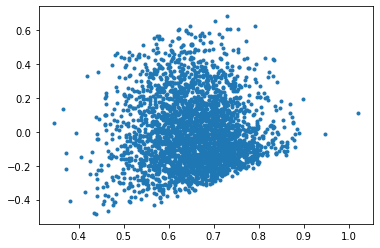

In [296]:
plt.plot(y_pred, (y_pred - y_test) ,".")

In [297]:
# is this distribution normal-distributed?

### plot predicted values against actual values

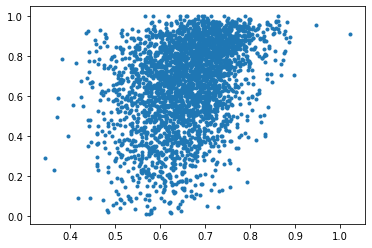

In [298]:
plt.plot(y_pred, y_test ,".")

#### compare to prediction of values that model was trained on

In [299]:
y_pred_train = reg.predict(X_train)

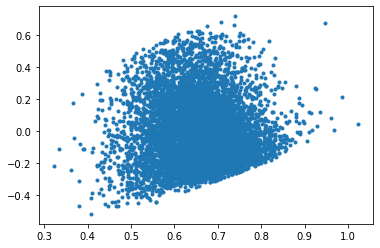

In [300]:
plt.plot(y_pred_train, y_pred_train - y_train ,".")

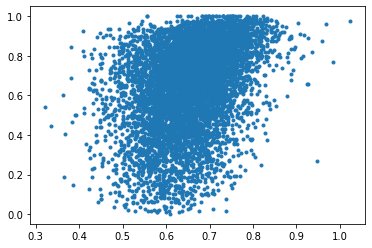

In [301]:
plt.plot(y_pred_train, y_train ,".")

Model overall seems to make better prediction for higher scores, which is unsurprising, as score histograms shows that most score are between 0.7-1.0 -> model is trained on a lot of data with scores in that interval, therefore makes better predictions for data with scores in that interval??

## check which variable has biggest effect on MSE

## get error when all variables are included

In [302]:
#trans= PowerTransformer()
#reg = LinearRegression()
#regression = TransformedTargetRegressor(regressor = reg, transformer = trans)
X_train, X_test, y_train, y_test = train_test_split(df_test.iloc[:,0:-1],df_test["score"] , test_size=0.3, random_state=42)
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
reg_rmse_full = mean_squared_error(y_pred, y_test)
explained_var_full = explained_variance_score(y_test, y_pred)

In [303]:
MSE, explained_var_full

(0.041616849090751126, 0.12119112135078747)

### get all possible combinations where one variable is missing

In [304]:
column_indices = list(range(0,len(df.columns)-1))

In [305]:
#df.columns[column_indices]

In [306]:
H = np.zeros((len(column_indices),len(column_indices)-1))

In [307]:
H.shape

(53, 52)

In [308]:
#column_indices

In [309]:
H[:] = np.array(range(0,len(df.columns)-1)).reshape(-1,1)

In [310]:
H = H.T

In [311]:
# create array of indices where always one variable is missing:
H = np.sort(H.reshape(len(column_indices),len(column_indices)-1))

In [312]:
#df.columns[18:]

In [313]:
#for j in H:
#    print(j)

### perform regression for all combinations, find out for which variable the difference in MSE is biggest compared to regression with all variables included

### correlation plot is better method? check 5 variables of biggest influences

In [314]:
Diff = np.ones(H.shape[0])
Diff_r2 = np.ones(H.shape[0])

In [318]:
max_differece = np.NINF
max_idx =0
min_difference = np.Inf
min_idx = 0
#Top5_absolute = np.zeros(5)
for idx, indices in enumerate(H):
    #print(np.setdiff1d(column_indices, H[idx][-1::-1]))
    #print(np.setdiff1d(column_indices, indices))
    # do linear regression
    #print(indices)
    trans= PowerTransformer()
    reg = LinearRegression()
    regression = TransformedTargetRegressor(regressor = reg, transformer = trans)
    X_train, X_test, y_train, y_test = train_test_split(df_test.iloc[:,indices],df_test["score"] , test_size=0.3, random_state=42)
    regression.fit(X_train, y_train)
    y_pred = regression.predict(X_test)
    reg_rmse = mean_squared_error(y_test, y_pred)
    #r2 = r2_score(y_test, y_pred)
    var_idx = np.setdiff1d(column_indices, indices)[0]
    #print(var_idx)
    #print("MSE: {}, name of missing variable: {}".format(reg_rmse, df.columns[var_idx]))
    #print(r2)
    
    # caclculate biggest difference in MSE of one missing variables compared to model with all variables.
    
    # calculate error of model with all variables - model with one missing variable
    Diff[idx] = reg_rmse_full- reg_rmse
    #Diff_r2[idx] = r2_full - r2
    
    #if error is positive, full model is worse than model with one variable removed.
    if Diff[idx] > max_differece:
        max_differece=Diff[idx]
        max_idx = var_idx
       
    
    # if error is negative, model with one variable removed is worse compared to full model
    if Diff[idx] < min_difference:
        min_difference=Diff[idx]
        min_idx = var_idx
        
    #for j in range(len(Top5_absolute)):
    #    if np.abs(Diff[idx])>Top5_absolute[j]:
            
    
    


In [319]:
max_differece

-0.000699606608394153

In [320]:
min_difference

-0.0018486976328165247

In [321]:
# max difference for Casual as price is already included?

In [322]:
# Lan Co-op worst variable for prediction?

In [323]:
df.columns[max_idx]

'MMO'

In [324]:
#release_year best_variable for prediction

In [325]:
df.columns[min_idx]

'relase_year'

## compare histograms conditioned on MMO, Indie and release_year

In [93]:
#df.loc[df['Valve Anti-Cheat enabled'] == 1]["score"]

(array([2.04185809e-03, 2.04185809e-03, 3.26697295e-02, 3.67534456e-02,
        4.69627361e-02, 9.39254722e-02, 1.49055641e-01, 1.73557938e-01,
        2.53190403e-01, 3.04236856e-01, 5.10464523e-01, 6.55436447e-01,
        8.90250128e-01, 1.19244513e+00, 1.61919347e+00, 2.20316488e+00,
        2.66870852e+00, 3.15262889e+00, 3.63450740e+00, 2.37876468e+00]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

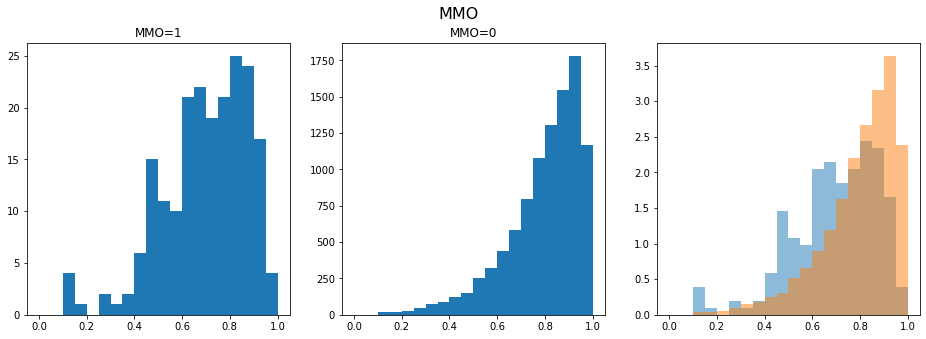

In [94]:
bins = np.linspace(0,1,21)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(16, 5))
fig.suptitle('MMO', fontsize=16)
ax1.hist(df.loc[df['MMO'] == 1]["score"],bins)
ax2.hist(df.loc[df["MMO"] == 0]["score"],bins)
ax1.set_title("MMO=1")
ax2.set_title("MMO=0")
ax3.hist(df.loc[df['MMO'] == 1]["score"],bins, density=True, alpha=0.5)
ax3.hist(df.loc[df["MMO"] == 0]["score"],bins, density=True, alpha=0.5)

eyeballing the plot shows already that MMOs are worse rated than non-MMOs. This goes against our prediction that that MMOs are better rated, as playing togehter is supposedly more fun (explanation could be bugs, toxic gamers etc.)

confirm with Whitney U-Test:

In [95]:
stats.mannwhitneyu(df.loc[df["MMO"] == 0]["score"], df.loc[df['MMO'] == 1]["score"],alternative="less")

MannwhitneyuResult(statistic=1368567.0, pvalue=1.0)

whitneyu provides evidence that distribution of MMO=1 is NOT higher than distribution of MMO=0.

(array([2.23588597e-03, 2.23588597e-03, 2.90665176e-02, 2.45947457e-02,
        3.13024036e-02, 7.82560089e-02, 1.20737842e-01, 1.38624930e-01,
        2.28060369e-01, 2.90665176e-01, 4.38233650e-01, 6.19340414e-01,
        9.03297932e-01, 1.20290665e+00, 1.62101733e+00, 2.18893236e+00,
        2.70542202e+00, 3.21296814e+00, 3.74734489e+00, 2.41475685e+00]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

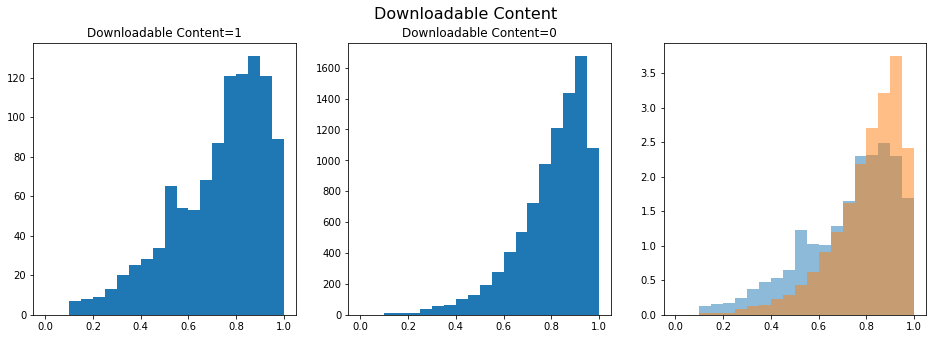

In [96]:
bins = np.linspace(0,1,21)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(16, 5))
fig.suptitle('Downloadable Content', fontsize=16)
ax1.hist(df.loc[df['Downloadable Content'] == 1]["score"],bins)
ax2.hist(df.loc[df['Downloadable Content'] == 0]["score"],bins)
ax1.set_title("Downloadable Content=1")
ax2.set_title("Downloadable Content=0")
ax3.hist(df.loc[df['Downloadable Content'] == 1]["score"],bins, density=True, alpha=0.5)
ax3.hist(df.loc[df['Downloadable Content'] == 0]["score"],bins, density=True, alpha=0.5)

In [97]:
#stats.mannwhitneyu(df.loc[df['Downloadable Content'] == 0]["score"], df.loc[df['Downloadable Content'] == 1]["score"],alternative="less")

(array([0.00516529, 0.00516529, 0.08780992, 0.06198347, 0.08780992,
        0.15495868, 0.20144628, 0.25309917, 0.30475207, 0.4803719 ,
        0.73863636, 0.79028926, 1.07438017, 1.24483471, 1.70454545,
        2.23140496, 2.74793388, 3.01136364, 3.00619835, 1.80785124]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

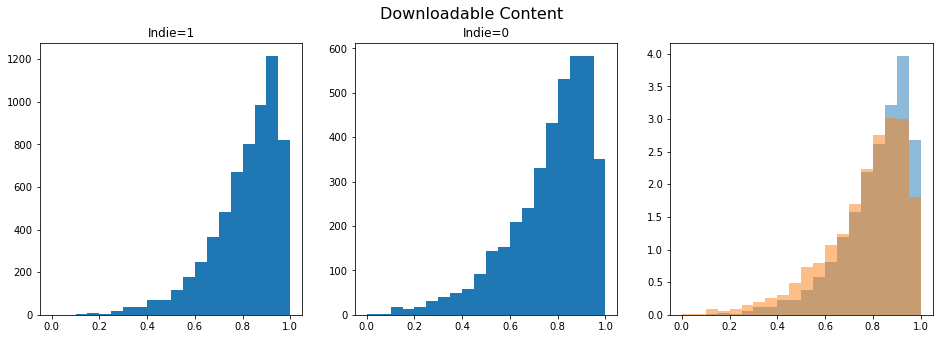

In [98]:
bins = np.linspace(0,1,21)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(16, 5))
fig.suptitle('Downloadable Content', fontsize=16)
ax1.hist(df.loc[df['Indie'] == 1]["score"],bins)
ax2.hist(df.loc[df['Indie'] == 0]["score"],bins)
ax1.set_title('Indie=1')
ax2.set_title('Indie=0')
ax3.hist(df.loc[df['Indie'] == 1]["score"],bins, density=True, alpha=0.5)
ax3.hist(df.loc[df['Indie'] == 0]["score"],bins, density=True, alpha=0.5)

In [99]:
stats.mannwhitneyu(df.loc[df['Indie'] == 0]["score"], df.loc[df['Indie'] == 1]["score"], alternative="less")

MannwhitneyuResult(statistic=10105239.0, pvalue=3.482767775659734e-36)

Whitneyu provides evidence that Indie games are better than non-indie games

In [100]:
#set(df["relase_year"])

In [101]:
A = np.zeros(len(set(df["relase_year"])))
for i in range(len(set(df["relase_year"]))):
    A[i] = np.mean(df.loc[lambda df: df.relase_year == 1998+i,"score"])
    

Text(0.5, 1.0, 'average game-score by release year')

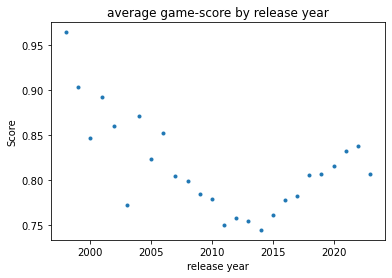

In [102]:
plt.plot(A,".")
plt.ylabel("Score")
plt.xlabel("release year")
plt.xticks([2,7,12,17,22],labels=["2000","2005", "2010", "2015", "2020"])
plt.title("average game-score by release year")

Dem anschein nach scheinen spiele mal besser (bewertet) gewesen zu sein. Der Plot ist Allerdings mit Vorsicht zu genießen,
z.B. für die Jahre 1998,1999 sind nur 1-2 Spiele im Datensatz.

# try comparing all histograms conditioned on all categorical variables:

In [103]:
#for idx in range(1, len(df.columns)-1):
#    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(14, 5))
#    fig.suptitle(df.columns[idx], fontsize=16)
#    ax1.hist(df.loc[df.iloc[:,idx] == 1]["score"],bins)
#    ax2.hist(df.loc[df.iloc[:,idx] == 0]["score"],bins)
#    ax1.set_title(df.columns[idx]+"=1")
#    ax2.set_title(df.columns[idx]+"=0")

# standardize data before using it as NN input

In [361]:
df_stand = df.copy(deep=True)

In [362]:
age = df["required_age"]

In [363]:
df_stand["required_age"] = (age-np.mean(age))/np.std(age)

In [364]:
price = np.array(df["price"]).reshape(-1)

In [365]:
df_stand["price"] = (price-np.mean(price))/np.std(price)

In [366]:
year = df["relase_year"]

In [367]:
df_stand["relase_year"] = (year-np.mean(year))/np.std(year)

In [368]:
df_stand["score"]

0       0.955032
1       0.733668
2       0.921053
3       0.953191
4       0.971429
          ...   
9995    0.921875
9996    0.660407
9997    0.677665
9998    0.973799
9999    0.601449
Name: score, Length: 10000, dtype: float64

In [369]:
#score = df["score"]

In [370]:
#df_stand["score"] = (score-np.mean(score))/np.std(score)

In [371]:
#df_stand

# try achieving less error with NN

In [372]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform

In [373]:
import datetime

In [374]:
device = (torch.device('cuda') if torch.cuda.is_available()
else torch.device('cpu'))

In [375]:
class SteamData(Dataset):
    def __init__(self, df):
        super().__init__()
        self.df = df
        self.data_size = len(self.df)
        self.num_variables = len(self.df.columns[0:-1])
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        IVs = torch.from_numpy(np.array(self.df.iloc[idx,0:-1],dtype=np.double))
        target = torch.from_numpy(np.array(self.df.loc[idx,"score"], dtype=np.double))
        
        sample = (IVs,target)
        
        #if self.transform:
        #    sample = self.transform(sample)
        return sample

In [376]:
Dataloader_steam = SteamData(df_stand)

In [377]:
BATCHSIZE = 64

In [378]:
generator=torch.Generator().manual_seed(42)

In [379]:
train_size = int(0.7 * len(df_stand))
test_size = len(df_stand) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(Dataloader_steam, [train_size, test_size], generator =generator)

In [380]:
SteamData_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCHSIZE,
shuffle=True)

SteamData_val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCHSIZE,
shuffle=False)

In [381]:
#for IVs, score in SteamData_train_loader:
#    print(IVs.shape) 
#    print(score.shape)

In [382]:
len(df.columns)

54

In [383]:
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(53,128)
        self.lin2 = nn.Linear(128,256)
        self.lin3 = nn.Linear(256,128)
        self.lin4 = nn.Linear(128,1)
        
    def forward(self,x):
        out = F.leaky_relu(self.lin1(x))
        out = F.leaky_relu(self.lin2(out))
        out = F.leaky_relu(self.lin3(out))
        out = F.sigmoid(self.lin4(out))
        return out

In [384]:
class NN3(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(53,128)
        self.lin2 = nn.Linear(128,256)
        self.lin3 = nn.Linear(256,128)
        self.lin4 = nn.Linear(128,1)
        
    def forward(self,x):
        out = F.sigmoid(self.lin1(x))
        out = F.sigmoid(self.lin2(out))
        out = F.sigmoid(self.lin3(out))
        out = F.sigmoid(self.lin4(out))
        return out

In [385]:
class NN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(53,256)
        self.lin2 = nn.Linear(256,256)
        self.lin3 = nn.Linear(256,256)
        self.lin4 = nn.Linear(256,1)
        
    def forward(self,x):
        out = F.tanh(self.lin1(x))
        out = F.tanh(self.lin2(out))
        out = F.tanh(self.lin3(out))
        out = F.tanh(self.lin4(out))
        return out

In [386]:
class NN3(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(53,128)
        self.lin2 = nn.Linear(128,256)
        self.lin3 = nn.Linear(256,128)
        self.lin4 = nn.Linear(128,1)
        
    def forward(self,x):
        out = F.tanh(self.lin1(x))
        out = F.tanh(self.lin2(out))
        out = F.tanh(self.lin3(out))
        out = F.tanh(self.lin4(out))
        return out

In [391]:
model = NN()

In [392]:
model = model.to(device=device)
model = model.double()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()
model.train()
n_epochs = 20

In [393]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
    loss_train = np.array(n_epochs)
    loss_val = np.array(n_epochs)
    for epoch in range(1,n_epochs+1):
        model.train()
        total_loss_train = 0
        total_loss_val = 0
        for IV, score in train_loader:
            IV = IV.to(device=device)
            score = score.to(device=device)
            #print(score)
            outputs = model(IV)
            #print(outputs)
            #print(outputs.shape)
            loss_train = loss_fn(outputs.flatten(), score)
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            
            total_loss_train+=loss_train
        
        for IV, score in val_loader:
            model.eval()
            with torch.no_grad():
                IV = IV.to(device=device)
                score = score.to(device=device)
                outputs = model(IV)
                #print(outputs)
                loss_val = loss_fn(outputs.flatten(), score)
                
                total_loss_val+=loss_val
       
            
            

        if epoch ==1 or epoch % 1 == 0:
            print("{} Epoch {}, Training loss {}, Validation Loss: {}".format(
            datetime.datetime.now(), epoch,
            total_loss_train/ len(train_loader), total_loss_val/len(val_loader)))

In [394]:
training_loop(n_epochs, optimizer, model, loss_fn, SteamData_train_loader, SteamData_val_loader)

C:\Users\Marco\anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


2023-01-27 17:41:45.873686 Epoch 1, Training loss 0.061748960867782914, Validation Loss: 0.025326012901554243
2023-01-27 17:41:48.582411 Epoch 2, Training loss 0.024216764205516085, Validation Loss: 0.023372078734407588
2023-01-27 17:41:51.155385 Epoch 3, Training loss 0.022687218185443597, Validation Loss: 0.022414028724833456
2023-01-27 17:41:53.649102 Epoch 4, Training loss 0.02192177071100071, Validation Loss: 0.02181533442262494
2023-01-27 17:41:56.089336 Epoch 5, Training loss 0.021227665951823103, Validation Loss: 0.021365788219348408
2023-01-27 17:41:58.640584 Epoch 6, Training loss 0.020757355353865716, Validation Loss: 0.02100640561444677
2023-01-27 17:42:01.127019 Epoch 7, Training loss 0.0203806899753596, Validation Loss: 0.02080571918549711
2023-01-27 17:42:03.726410 Epoch 8, Training loss 0.02005404111702443, Validation Loss: 0.020712521709268968
2023-01-27 17:42:06.166586 Epoch 9, Training loss 0.019884125073109347, Validation Loss: 0.02059524019423685
2023-01-27 17:42:0

In [395]:
len(df.columns)

54

## check residual plot for NN

In [396]:
test_samples = np.zeros((len(SteamData_val_loader.dataset),53))

In [397]:
test_samples_score = np.zeros(len(SteamData_val_loader.dataset))

In [398]:
idx=0
for IV,score in SteamData_val_loader:
    #print(IV.shape[0])
    #IV.shape[0]
    test_samples[idx:idx+IV.shape[0]] = IV
    test_samples_score[idx:idx+IV.shape[0]] = score
    idx=idx+IV.shape[0]

In [399]:
test_samples = (torch.from_numpy(test_samples)).to(device)

In [400]:
with torch.no_grad():
    y_pred_NN = model(test_samples)

C:\Users\Marco\anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [401]:
#y_pred_NN[:100]

In [402]:
test_samples_score

array([0.88461538, 0.78181818, 0.79049296, ..., 0.92041522, 0.84759456,
       0.83950617])

In [403]:
y_pred_NN 

tensor([[0.8361],
        [0.6914],
        [0.8036],
        ...,
        [0.8297],
        [0.8246],
        [0.8930]], device='cuda:0', dtype=torch.float64)

In [404]:
explained_variance_score(test_samples_score,y_pred_NN.cpu().numpy())

0.16647645455064763

In [405]:
y_pred_NN.cpu().numpy().reshape(-1)

array([0.83610838, 0.69138183, 0.80360951, ..., 0.82970871, 0.82460898,
       0.89304716])

In [406]:
(y_pred_NN.cpu().numpy().reshape(-1)- test_samples_score).shape

(3000,)

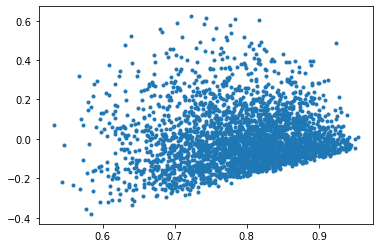

In [407]:
plt.plot(y_pred_NN.cpu().numpy().reshape(-1) ,y_pred_NN.cpu().numpy().reshape(-1)- test_samples_score,".")

### predicted vs actual values

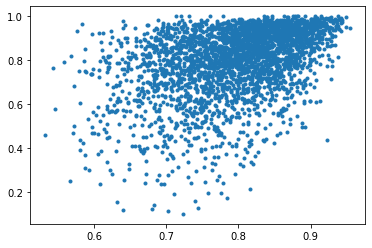

In [408]:
plt.plot(y_pred_NN.cpu().numpy(),test_samples_score,".")

# plot difference between regression and NN

In [409]:
X_train, X_test, y_train, y_test = train_test_split(df[df.columns[best_fit_indices_min[1]]],df["score"] , test_size=0.3, random_state=42)
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
explained_var = explained_variance_score(y_test, y_pred)
MSE = mean_squared_error(y_pred, y_test)

In [410]:
explained_var, MSE

(0.12119583473834483, 0.021182211904347804)

Text(0.5, 0, 'residuals/erros')

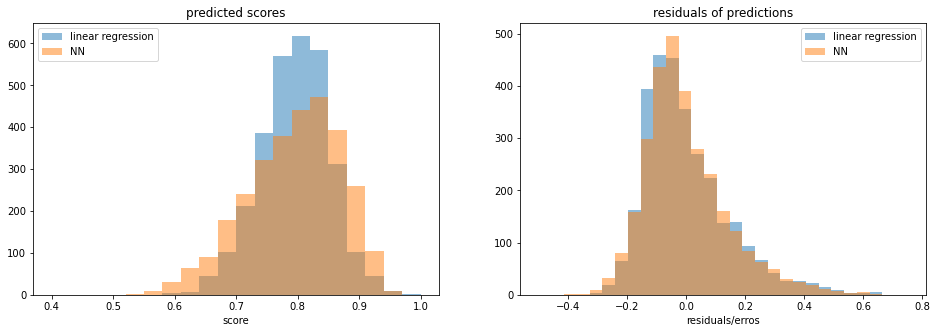

In [425]:
bins = np.linspace(0.4,1,21)
bins2 = np.linspace(-0.5,0.75,30)
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16, 5))
ax1.hist(y_pred, bins, alpha=0.5, label="linear regression")
ax1.hist(y_pred_NN.cpu().numpy().reshape(-1), bins, alpha=0.5, label="NN")
ax1.legend()
ax1.set_title("predicted scores")
ax1.set_xlabel("score")
ax2.hist(y_pred-y_test, bins2, alpha=0.5, label="linear regression")
ax2.hist(y_pred_NN.cpu().numpy().reshape(-1)- test_samples_score, bins2, alpha=0.5, label="NN")
ax2.legend()
ax2.set_title("residuals of predictions")
ax2.set_xlabel("residuals/erros")